In [34]:
import pandas as pd
import glob
import os
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}
task_2_dataset = {"ONE_VS_NINE": datasets.ClassificationTaskType.ONE_VS_NINE,
"HIGH_VS_95LOW": datasets.ClassificationTaskType.HIGH_VS_95LOW,
"HIGH_VS_LOOSER": datasets.ClassificationTaskType.HIGH_VS_LOOSER}


In [30]:
def get_attr_from_records(records, attributor_name, y_true):
    """Get the attributions for a given attributor and y_true."""
    attr = np.stack(
        list(map(
            lambda x: np.array(x[attributor_name]).reshape((11, 20)),
            filter(lambda x: x["y_true"] in y_true, records)
        )))
        
    return attr
def get_onehotstack_from_records(records, y_true = (0, 1)):
    """Get the onehot stack from the records."""
    slides = [record["slide"] for record in records if record["y_true"] in y_true]
    onehots = [preprocessing.onehot_encode(slide) for slide in slides]
    onehot_stack = np.stack(onehots)
    return onehot_stack


def get_aa_atributions(attr_records, attributor_name = "DeepLIFT_LOCAL_v2.0-2"):


    attr_stack = get_attr_from_records(attr_records, attributor_name, (0, 1))  # Nx11x20

    onehot_stack = get_onehotstack_from_records(attr_records, (0, 1))  # Nx220
    attr_aa = attr_stack[onehot_stack.reshape((-1, 11, 20)) == 1].reshape(-1, 11)  # Nx11
    return attr_aa

In [57]:
attr_records[0].keys()

dict_keys(['slide', 'logits', 'expits', 'y_pred', 'y_true', 'is_pred_correct', 'DeepLIFT_LOCAL_v2.0-2', 'DeepLIFT_GLOBAL_R10_v2.0-2', 'exec_time', 'DeepLIFT_Reveal_cancel'])

In [54]:
attr_df

,Slide,DeepLift_reveal_cancel,y_pred,y_true
0,AKELLLLRLAL,"[0.6644294857978821, -2.4552788734436035, 1.06...",1,1
1,ALFLLLRYDAM,"[0.7544631958007812, 2.232804775238037, 1.9163...",1,1
2,CAIWGLGRLFF,"[1.9822471141815186, -1.7645435333251953, -0.2...",1,0
3,CASMLLLRFSM,"[1.7292696237564087, -3.3700764179229736, -1.8...",1,1
4,CARWLLLYFFH,"[2.415796995162964, -1.0979620218276978, 0.059...",1,1
...,...,...,...,...
9995,CARSPGTGAYG,"[-0.17566260695457458, -7.794863224029541, -7....",0,0
9996,CARGKTTERAM,"[1.5556238889694214, -8.485574722290039, -6.76...",0,0
9997,ASGDYGSSTDY,"[-2.027280330657959, -7.74960470199585, -5.917...",0,0
9998,CARKGDGSKAM,"[0.9521848559379578, -9.094497680664062, -6.68...",0,0


In [31]:
attr_aa = get_aa_atributions(attr_records)

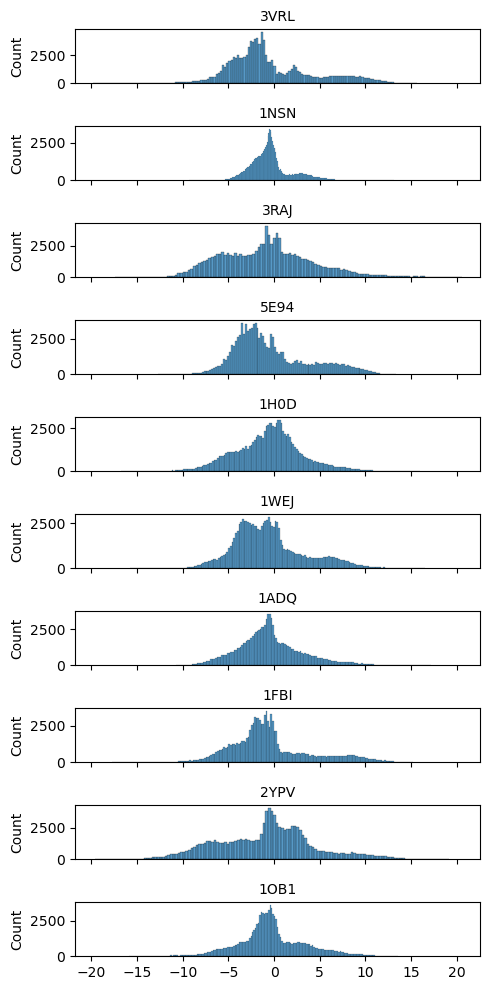

In [52]:
fig, ax = plt.subplots(10, figsize=(5,10), sharex=True)
for i, ag in enumerate(config.ANTIGENS): 
    seed=0
    split=0
    ex_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/high_vs_95low/seed_{seed}/split_{split}/{ag}*/attributions/reveal_cancel/attribution_records.json')[0]
    with open(ex_path, "r") as f:
        attr_records = json.load(f)
    attr_aa = get_aa_atributions(attr_records)
    sns.histplot(attr_aa.flatten(), ax=ax[i])
    ax[i].set_title(ag, fontsize= 10)
plt.tight_layout()

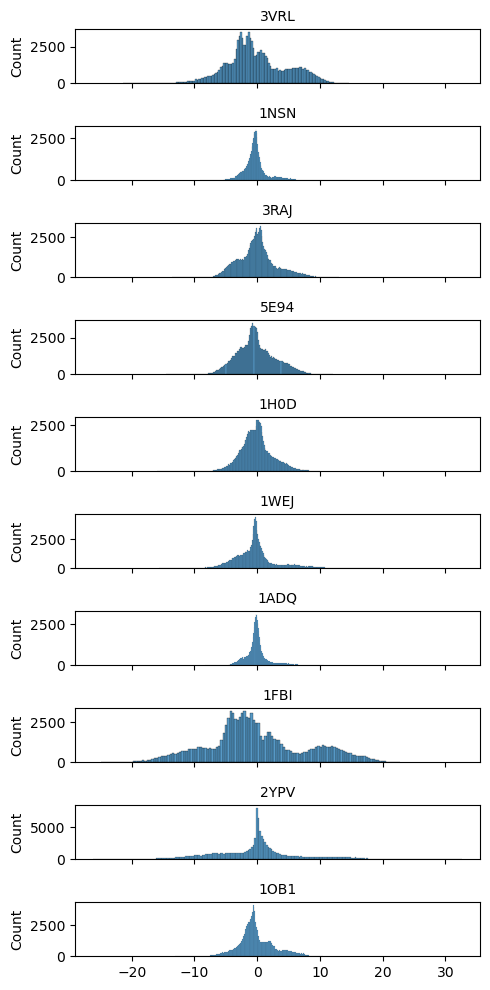

In [53]:
fig, ax = plt.subplots(10, figsize=(5,10), sharex=True)
for i, ag in enumerate(config.ANTIGENS): 
    seed=0
    split=0
    ex_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/high_vs_looser/seed_{seed}/split_{split}/{ag}*/attributions/reveal_cancel/attribution_records.json')[0]
    with open(ex_path, "r") as f:
        attr_records = json.load(f)
    attr_aa = get_aa_atributions(attr_records)
    sns.histplot(attr_aa.flatten(), ax=ax[i])
    ax[i].set_title(ag, fontsize= 10)
plt.tight_layout()

In [16]:
"""#might be needed copied from Eugen
from itertools import permutations


task_types = (
    datasets.ClassificationTaskType.ONE_VS_ONE,
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
)

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("./torch_models/Frozen_MiniAbsolut_ML/")
)

def get_miniabsolut_dataframes(task, load_energy_contributions=False):
    """Load the dataframes based on MiniAbsolut, from task
    These dataframes contain extra info, such as binding energies.
    """
    #if task.split_id == 42:
        #miniabsolut_path = Path("..//MiniAdatabsolut")
    #elif task.split_id in [0, 1, 2, 3, 4]:
        #miniabsolut_path = Path(f"../data/MiniAbsolut_Splits/MiniAbsolut_Seed{task.split_id}")

    miniabsolut_path = Path(f"../data/MiniAbsolut_Splits/MiniAbsolut_Seed4")
    
    ag_pos_dir = miniabsolut_path / task.ag_pos
    if load_energy_contributions:
        ag_pos_dir = ag_pos_dir / "energy_contributions"
        suffix = "_absolut_energy_contributions"
        header = 1
    else:
        suffix = ""
        header = 0
    
    df_pos = pd.read_csv(ag_pos_dir / f"high_test_5000{suffix}.tsv", sep="\t", header=header)
    df_pos["class"] = "positive"

    if task.task_type == datasets.ClassificationTaskType.HIGH_VS_95LOW:
        df_neg = pd.read_csv(ag_pos_dir / f"95low_test_5000{suffix}.tsv", sep='\t', header=header)
        df_neg["class"] = "negative"
    elif task.task_type == datasets.ClassificationTaskType.HIGH_VS_LOOSER:
        df_neg = pd.read_csv(ag_pos_dir / f"looserX_test_5000{suffix}.tsv", sep='\t', header=header)
        df_neg["class"] = "negative"
    elif task.task_type in (datasets.ClassificationTaskType.ONE_VS_ONE, datasets.ClassificationTaskType.ONE_VS_NINE):
        # raise ValueError("Not implemented.")
        df_neg = pd.DataFrame()
    
    df = pd.concat([df_pos, df_neg], axis=0)
    
    return df"""

In [17]:
"""### s
def get_attr_from_records(records, attributor_name, y_true):
    """Get the attributions for a given attributor and y_true."""
    attr = np.stack(
        list(map(
            lambda x: np.array(x[attributor_name]).reshape((11, 20)),
            filter(lambda x: x["y_true"] in y_true, records)
        )))
        
    return attr

def get_onehotstack_from_records(records, y_true = (0, 1)):
    """Get the onehot stack from the records."""
    slides = [record["slide"] for record in records if record["y_true"] in y_true]
    onehots = [preprocessing.onehot_encode(slide) for slide in slides]
    onehot_stack = np.stack(onehots)
    return onehot_stack
    
def load_energy_contributions_from_task(task, load_slide_df = False, attributions_toload="v2.0-2", attributor_name = "DeepLIFT_LOCAL_v2.0-2"):

    # Get energy contributions and attributions
    df = get_miniabsolut_dataframes(task, load_energy_contributions=True)
    energy_dict = df.set_index("Slide").to_dict(orient="index")
    for slide in energy_dict.keys():
        energy_dict[slide]["energies"] = utils.extract_contributions_from_string(energy_dict[slide]["contribPerAAparaBind"])[1]
        energy_dict[slide]["energies_fold"] = utils.extract_contributions_from_string(energy_dict[slide]["contribPerAAparaFold"])[1]
        energy_dict[slide]["energies_total"] = (np.array(energy_dict[slide]["energies"]) + np.array(energy_dict[slide]["energies_fold"])).tolist()

    # Get attributions per amino acid
    task = loader.load(task, attributions_toload=attributions_toload)
    attributor_name = attributor_name
    attr_stack = get_attr_from_records(task.attributions, attributor_name, (0, 1))  # Nx11x20
    onehot_stack = get_onehotstack_from_records(task.attributions, (0, 1))  # Nx220
    attr_aa = attr_stack[onehot_stack.reshape((-1, 11, 20)) == 1].reshape(-1, 11)  # Nx11
    attr_dict = {record["slide"]: {**record, **{"attribution_existingaa": attr_aa[i, :]}}
                for i, record in enumerate(task.attributions)}

    #add here option to load reveal_cancel_attributions

    # Combine dictionaries
    slide_records = []
    
    #for slide in energy_dict.keys():
    comon_slides = set(attr_dict.keys()).intersection(set(energy_dict.keys()))
    for slide in comon_slides:
        dataset_class = energy_dict[slide]["class"]
        energies = energy_dict[slide]["energies"]
        energies_fold = energy_dict[slide]["energies_fold"]
        energies_total = energy_dict[slide]["energies_total"]
        attrs = attr_dict[slide]["attribution_existingaa"]
        
        # Correlation between energy and attribution with scipy
        r, p = pearsonr(energies, attrs)
        r_fold, p_fold = pearsonr(energies_fold, attrs)
        r_total, p_total = pearsonr(energies_total, attrs)
        slide_records.append({
            "slide": slide,
            "class": dataset_class,
            "energies": energies,
            "attributions": attrs,
            "r": r,
            "p": p,
            "r_fold": r_fold,
            "p_fold": p_fold,
            "r_total": r_total,
            "p_total": p_total,
        })
    slide_df = pd.DataFrame.from_records(slide_records)
    
    mean = slide_df["r"].mean()
    std = slide_df["r"].std()
    mean_pos = slide_df[slide_df["class"] == "positive"]["r"].mean()
    std_pos = slide_df[slide_df["class"] == "positive"]["r"].std()
    mean_neg = slide_df[slide_df["class"] == "negative"]["r"].mean()
    std_neg = slide_df[slide_df["class"] == "negative"]["r"].std()

    mean_fold = slide_df["r_fold"].mean()
    std_fold = slide_df["r_fold"].std()
    mean_pos_fold = slide_df[slide_df["class"] == "positive"]["r_fold"].mean()
    std_pos_fold = slide_df[slide_df["class"] == "positive"]["r_fold"].std()
    mean_neg_fold = slide_df[slide_df["class"] == "negative"]["r_fold"].mean()
    std_neg_fold = slide_df[slide_df["class"] == "negative"]["r_fold"].std()

    mean_total = slide_df["r_total"].mean()
    std_total = slide_df["r_total"].std()
    mean_pos_total = slide_df[slide_df["class"] == "positive"]["r_total"].mean()
    std_pos_total = slide_df[slide_df["class"] == "positive"]["r_total"].std()
    mean_neg_total = slide_df[slide_df["class"] == "negative"]["r_total"].mean()
    std_neg_total = slide_df[slide_df["class"] == "negative"]["r_total"].std()
    
    stats = {
        "task_type": task.task_type.to_str(),
        "ag_pos": task.ag_pos,
        "ag_neg": task.ag_neg,
        "seed_id": task.seed_id,
        "split_id": task.split_id,
        "mean": mean,
        "std": std,
        "mean_pos": mean_pos,
        "std_pos": std_pos,
        "mean_neg": mean_neg,
        "std_neg": std_neg,
        "mean_fold": mean_fold,
        "std_fold": std_fold,
        "mean_pos_fold": mean_pos_fold,
        "std_pos_fold": std_pos_fold,
        "mean_neg_fold": mean_neg_fold,
        "std_neg_fold": std_neg_fold,
        "mean_total": mean_total,
        "std_total": std_total,
        "mean_pos_total": mean_pos_total,
        "std_pos_total": std_pos_total,
        "mean_neg_total": mean_neg_total,
        "std_neg_total": std_neg_total,
    }
    if load_slide_df:
        return stats, slide_df
    else:
        return stats
    """

In [11]:
#for figure 2D with reveal cancel rule
attributions_file = glob.glob("../data/deeplift_revealcancel/*")
all_stats_reveal_cancel = []
for attribution_path in attributions_file:
    file_name = os.path.basename(attribution_path)
    task_name, ag, seed, split = file_name.split("__")[:-1]
    seed = int(seed)
    split = int(split)
    task_type = task_2_dataset[task_name]#datasets.ClassificationTaskType.ONE_VS_NINE
    task = datasets.ClassificationTask(
                            task_type=task_type,
                            ag_pos=ag,
                            ag_neg="auto",
                            seed_id=seed,
                            split_id=split,
                        )
    stats = load_energy_contributions_from_task(task, load_slide_df = False, attributions_toload="reveal_cancel", attributor_name = "DeepLIFT_Reveal_cancel")
    all_stats_reveal_cancel.append(stats)

df_attr_revcan = pd.DataFrame.from_records(all_stats_reveal_cancel)

NameError: name 'get_miniabsolut_dataframes' is not defined